<h1> Feed Forward Neural Network</h1>

Work Done by:<br>
Mohammed Safi Ur Rahman Khan - DA24D004

The goal of this work is two fold: <br>
(i) implement and use gradient descent (and its variants) with backpropagation for a classification task <br>
(ii) Getting familiar with wandb which is a cool tool for running and keeping track of a large number of experiments

In this project we have implemented a feedforward neural network and written the backpropagation code for training the network. We have used numpy for all matrix/vector operations. We have not used any automatic differentiation packages.<br> <br>
This network is trained and tested using the Fashion-MNIST dataset. Specifically, given an input image (28 x 28 = 784 pixels) from the Fashion-MNIST dataset, the network is trained to classify the image into 1 of 10 classes.

### Declaration

For the purpose of this project, we have used help from various online resources for help in understanding some concepts, intuition about the code flow, Debugging the various errors, etc.<br> <br>
Wherever possible we have credited all the resources in their respective sections. <br> <br>
Some of the frequently used resources include:<br>
<ul> <li> StackOverflow (and its variants)</li>
<li> Github Copilot </li>
<li> ChatGPT </li>
<li> Towards Data Science Blogs</li>
<li> machinelearningmastery.com </li>
<li> Medium Blogs </li>
<li> Kaggle </li>
<li> Lecture slides from Prof. Mitesh Khapra's  CS6910-Fundamentals of Deep Learning course.</li>
</ul>
<br> <br>

We have tried to include as many resources that we have used, but in all possibiliy we may have missed many.<br>
We profusely apologize to any other authors for using your resouces and content but failing to appropriately credit you.




## Importing Necessary Libraries

In [4]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import copy 
from tqdm import tqdm
import random
import tensorflow as tf
import seaborn as sn

import wandb

entity_name = "safikhan"
project_name = "DA6401_Assignment_1"

# 1. About the Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.<br>
<br>
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. <br><br>

<b>Labels:</b>

Each training and test example is assigned to one of the following labels:
<ul>
<li> T-shirt/top
<li> Trouser
<li> Pullover
<li> Dress
<li> Coat
<li> Sandal
<li> Shirt
<li> Sneaker
<li> Bag
<li> Ankle boot
</ul>

In [10]:
from utils.data_prep import prepare_data

def plot_locally():

  '''This function is used to plot a single image of each class label on the 
  local machine'''

  #getting all the datasets
  xtrain, xval, xtest, ytrain, yval, ytest, labels = prepare_data()

  # Creating training dataset
  train=list(zip(xtrain, ytrain))

  # plotting a single image from each class
  sample_images=[]
  wandb_arr=[]
  i=1
  plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")

  while(len(sample_images)!=10):
    n=random.randrange(0,len(train))
    lab_index=np.asarray(np.nonzero(train[n][1]))[0][0]
    
    if(lab_index not in sample_images):
      plt.subplot(3,5,i)
      sample_images.append(lab_index)
      plt.title(labels[lab_index])
      plt.axis(False)
      plt.imshow(train[n][0].reshape((28,28)))
      i=i+1

Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


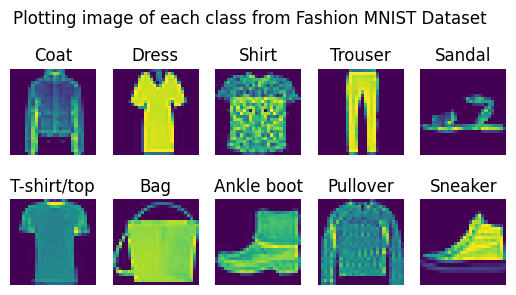

In [11]:
plot_locally()

In [12]:
def plot_images_wandb(entity_name,project_name):
  # Here we are implementing the same above logic but plotting all the images on
  # Wandb.

  # Enter the entity and project details from wandb.ai
  wandb.init(entity=entity_name,project=project_name, name="log_images")

  # Loading dataset
  xtrain, xval, xtest, ytrain, yval, ytest, labels = prepare_data()

  # Creating training dataset
  train=list(zip(xtrain, ytrain))


  sample_images=[]
  wandb_arr=[]
  i=1
  plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")
  while(len(sample_images)!=10):
    n = random.randrange(0,len(train))
    lab_index = np.asarray(np.nonzero(train[n][1]))[0][0]
    if(lab_index not in sample_images):
      sample_images.append(lab_index)
      wandb_arr.append(wandb.Image(train[n][0].reshape((28,28)), caption=labels[lab_index]))
      i = i+1
  wandb.log({"images":wandb_arr})
  wandb.finish()


In [13]:
plot_images_wandb(entity_name,project_name)

Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


<Figure size 640x480 with 0 Axes>

# Evaluating the Model

In [2]:
from scripts.model import *
from scripts.optimizers import *
from scripts.loss_functions import *
from scripts.activation import *
from scripts.data_prep import *
from train import fit

In [3]:
def plot_confmat_wandb(entity_name, project_name):
    # NOTE: Change these values according to the observations
    # made from the parallel coordinate plot from wandb.ai. These are the best 
    # hyperparameters as observed.
    
  X_train, X_val, X_test, y_train, y_val, y_test, labels = prepare_data()
    
  config_final_test = {
        'number_hidden_layers': 5,
        'number_neurons': 128,
        'learning_rate': 0.0001,
        'initialization_type': "xavier",
        'activation_function':'relu',
        'mini_batch_size' : 32,
        'max_epochs': 20,
        'lambd': 0.0005,
        'optimization_function': "nadam",
        'loss_function': "cross_entropy"
        
  }

  #initializing the run
  wandb.init(config=config_final_test, project = project_name, entity=entity_name)
  config = wandb.config


  #Forming the layer_sizes i.e., the architecture of our neural network
  layer_sizes = [784]
  for i in range(config.number_hidden_layers):
      layer_sizes = layer_sizes + [config.number_neurons]
  layer_sizes  = layer_sizes + [10]

  #storing the hyperparameters in local variables
  learning_rate = config.learning_rate
  initialization_type = config.initialization_type
  activation_function = config.activation_function
  loss_function = config.loss_function
  mini_batch_size = config.mini_batch_size
  max_epochs = config.max_epochs
  lambd = config.lambd
  opt_fun = config.optimization_function

  #Choosing the correct optimization function
  if opt_fun == "adam":
      optimization_function = adam
  elif opt_fun == "nadam":
      optimization_function = nadam
  elif opt_fun == "mini_batch_gd":
      optimization_function = mini_batch_gd
  elif opt_fun == "momentum_gd":
      optimization_function = momentum_gd
  elif opt_fun == "nesterov_gd":
      optimization_function = nesterov_gd
  elif opt_fun == "rmsprop":
      optimization_function = rmsprop
  else:
      print("Wrong optimization function")
      exit()

  #set this to TRUE to log the data to wandb
  wandb_log=True

  #calling the fit function to train the model using the best hyperparamters obtained from above
  parameters_for_test = fit(X_train, y_train, X_val, y_val, layer_sizes,wandb_log, learning_rate, initialization_type, activation_function, loss_function, mini_batch_size, max_epochs, lambd, optimization_function)
  res = predict(X_test,y_test, parameters_for_test, activation_function, layer_sizes)
    
  wandb.run.name = "Confusion Matrix"

  # Converting the one hot encoded vectors back to label_id's
  y_t=[]
  for k in range(len(y_test)):
      y_t.append(y_test[k].argmax())

  y_pred=[]
  for k in range(len(res)):
      y_pred.append(res[k].argmax())

  #calculating the test accuracy using the test data
  test_accuracy=calc_test_accuracy(y_pred,y_t)
  print(test_accuracy)
  wandb.log({"conf_mat":wandb.plot.confusion_matrix(preds=y_pred,y_true=y_t,class_names=labels),"Test Accuracy": test_accuracy}) 
    

  wandb.run.save()
  wandb.run.finish()

  return y_pred,y_t

In [5]:
plot_confmat_wandb(entity_name, project_name)

Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: safikhan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training the model


100%|██████████| 20/20 [09:15<00:00, 27.75s/it]


Training Accuracy: 93.99814814814815
Validation Accuracy: 89.11666666666666
87.82


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Test Accuracy,▁
Train_Accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇█████
Train_Loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Validation_Accuracy,▁▃▄▅▆▆▆▇▇█▇▇█▇████▇█
Validation_loss,█▄▃▂▁▁▁▁▁▁▂▃▃▃▄▄▄▅▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Test Accuracy,87.82
Train_Accuracy,93.99815
Train_Loss,0.15875
Validation_Accuracy,89.11667
Validation_loss,0.40615


([9,
  2,
  1,
  1,
  6,
  1,
  4,
  6,
  5,
  7,
  4,
  5,
  5,
  3,
  4,
  1,
  2,
  2,
  8,
  0,
  2,
  5,
  7,
  5,
  1,
  2,
  6,
  0,
  9,
  6,
  8,
  8,
  3,
  3,
  8,
  0,
  7,
  5,
  7,
  9,
  0,
  1,
  6,
  7,
  6,
  7,
  2,
  1,
  2,
  6,
  4,
  2,
  5,
  8,
  2,
  2,
  8,
  4,
  8,
  0,
  7,
  7,
  8,
  5,
  1,
  1,
  0,
  4,
  7,
  8,
  7,
  0,
  2,
  6,
  2,
  3,
  1,
  2,
  8,
  4,
  1,
  8,
  5,
  9,
  5,
  0,
  3,
  2,
  0,
  2,
  5,
  3,
  6,
  7,
  1,
  8,
  0,
  1,
  4,
  2,
  3,
  6,
  7,
  2,
  7,
  8,
  5,
  9,
  9,
  4,
  2,
  5,
  7,
  0,
  5,
  2,
  8,
  6,
  7,
  8,
  0,
  0,
  9,
  9,
  3,
  0,
  8,
  4,
  1,
  5,
  4,
  1,
  9,
  1,
  8,
  4,
  6,
  1,
  2,
  5,
  1,
  6,
  0,
  0,
  1,
  6,
  1,
  3,
  2,
  2,
  3,
  2,
  1,
  3,
  5,
  6,
  4,
  7,
  9,
  3,
  7,
  2,
  3,
  5,
  0,
  9,
  4,
  7,
  4,
  2,
  0,
  5,
  6,
  1,
  2,
  1,
  3,
  0,
  9,
  1,
  0,
  9,
  3,
  6,
  7,
  9,
  9,
  4,
  4,
  7,
  1,
  2,
  3,
  6,
  3,
  2,
  8,
  3,
  6,
  1,
